Источник Roboflow: https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb

## Установка пакетов

In [1]:
# проверка доступа к GPU
!nvidia-smi

Tue Feb 20 16:49:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
# установка YOLO

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [5]:
from ultralytics import YOLO

from IPython.display import display, Image

## Загрузка датасета

In [23]:
# загрузка датасета с детекцией нечищенного снега из roboflow
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0tYeD4L6zphTfjufsIKY")
project = rf.workspace("snowcity").project("uncleaned-snow")
dataset = project.version(3).download("yolov8")


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to Uncleaned-snow-3 in yolov8:: 100%|██████████| 1550/1550 [00:01<00:00, 1527.68it/s]


## Обучение модели

In [24]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

/content
New https://pypi.org/project/ultralytics/8.1.16 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/Uncleaned-snow-3/data.yaml, epochs=25, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualiz

In [25]:
!ls {HOME}/runs/detect/train4/

args.yaml					     R_curve.png	 val_batch0_labels.jpg
confusion_matrix_normalized.png			     results.csv	 val_batch0_pred.jpg
confusion_matrix.png				     results.png	 val_batch1_labels.jpg
events.out.tfevents.1708450707.8c291a930c15.13857.0  train_batch0.jpg	 val_batch1_pred.jpg
F1_curve.png					     train_batch1.jpg	 val_batch2_labels.jpg
labels_correlogram.jpg				     train_batch2.jpg	 val_batch2_pred.jpg
labels.jpg					     train_batch570.jpg  weights
P_curve.png					     train_batch571.jpg
PR_curve.png					     train_batch572.jpg


/content


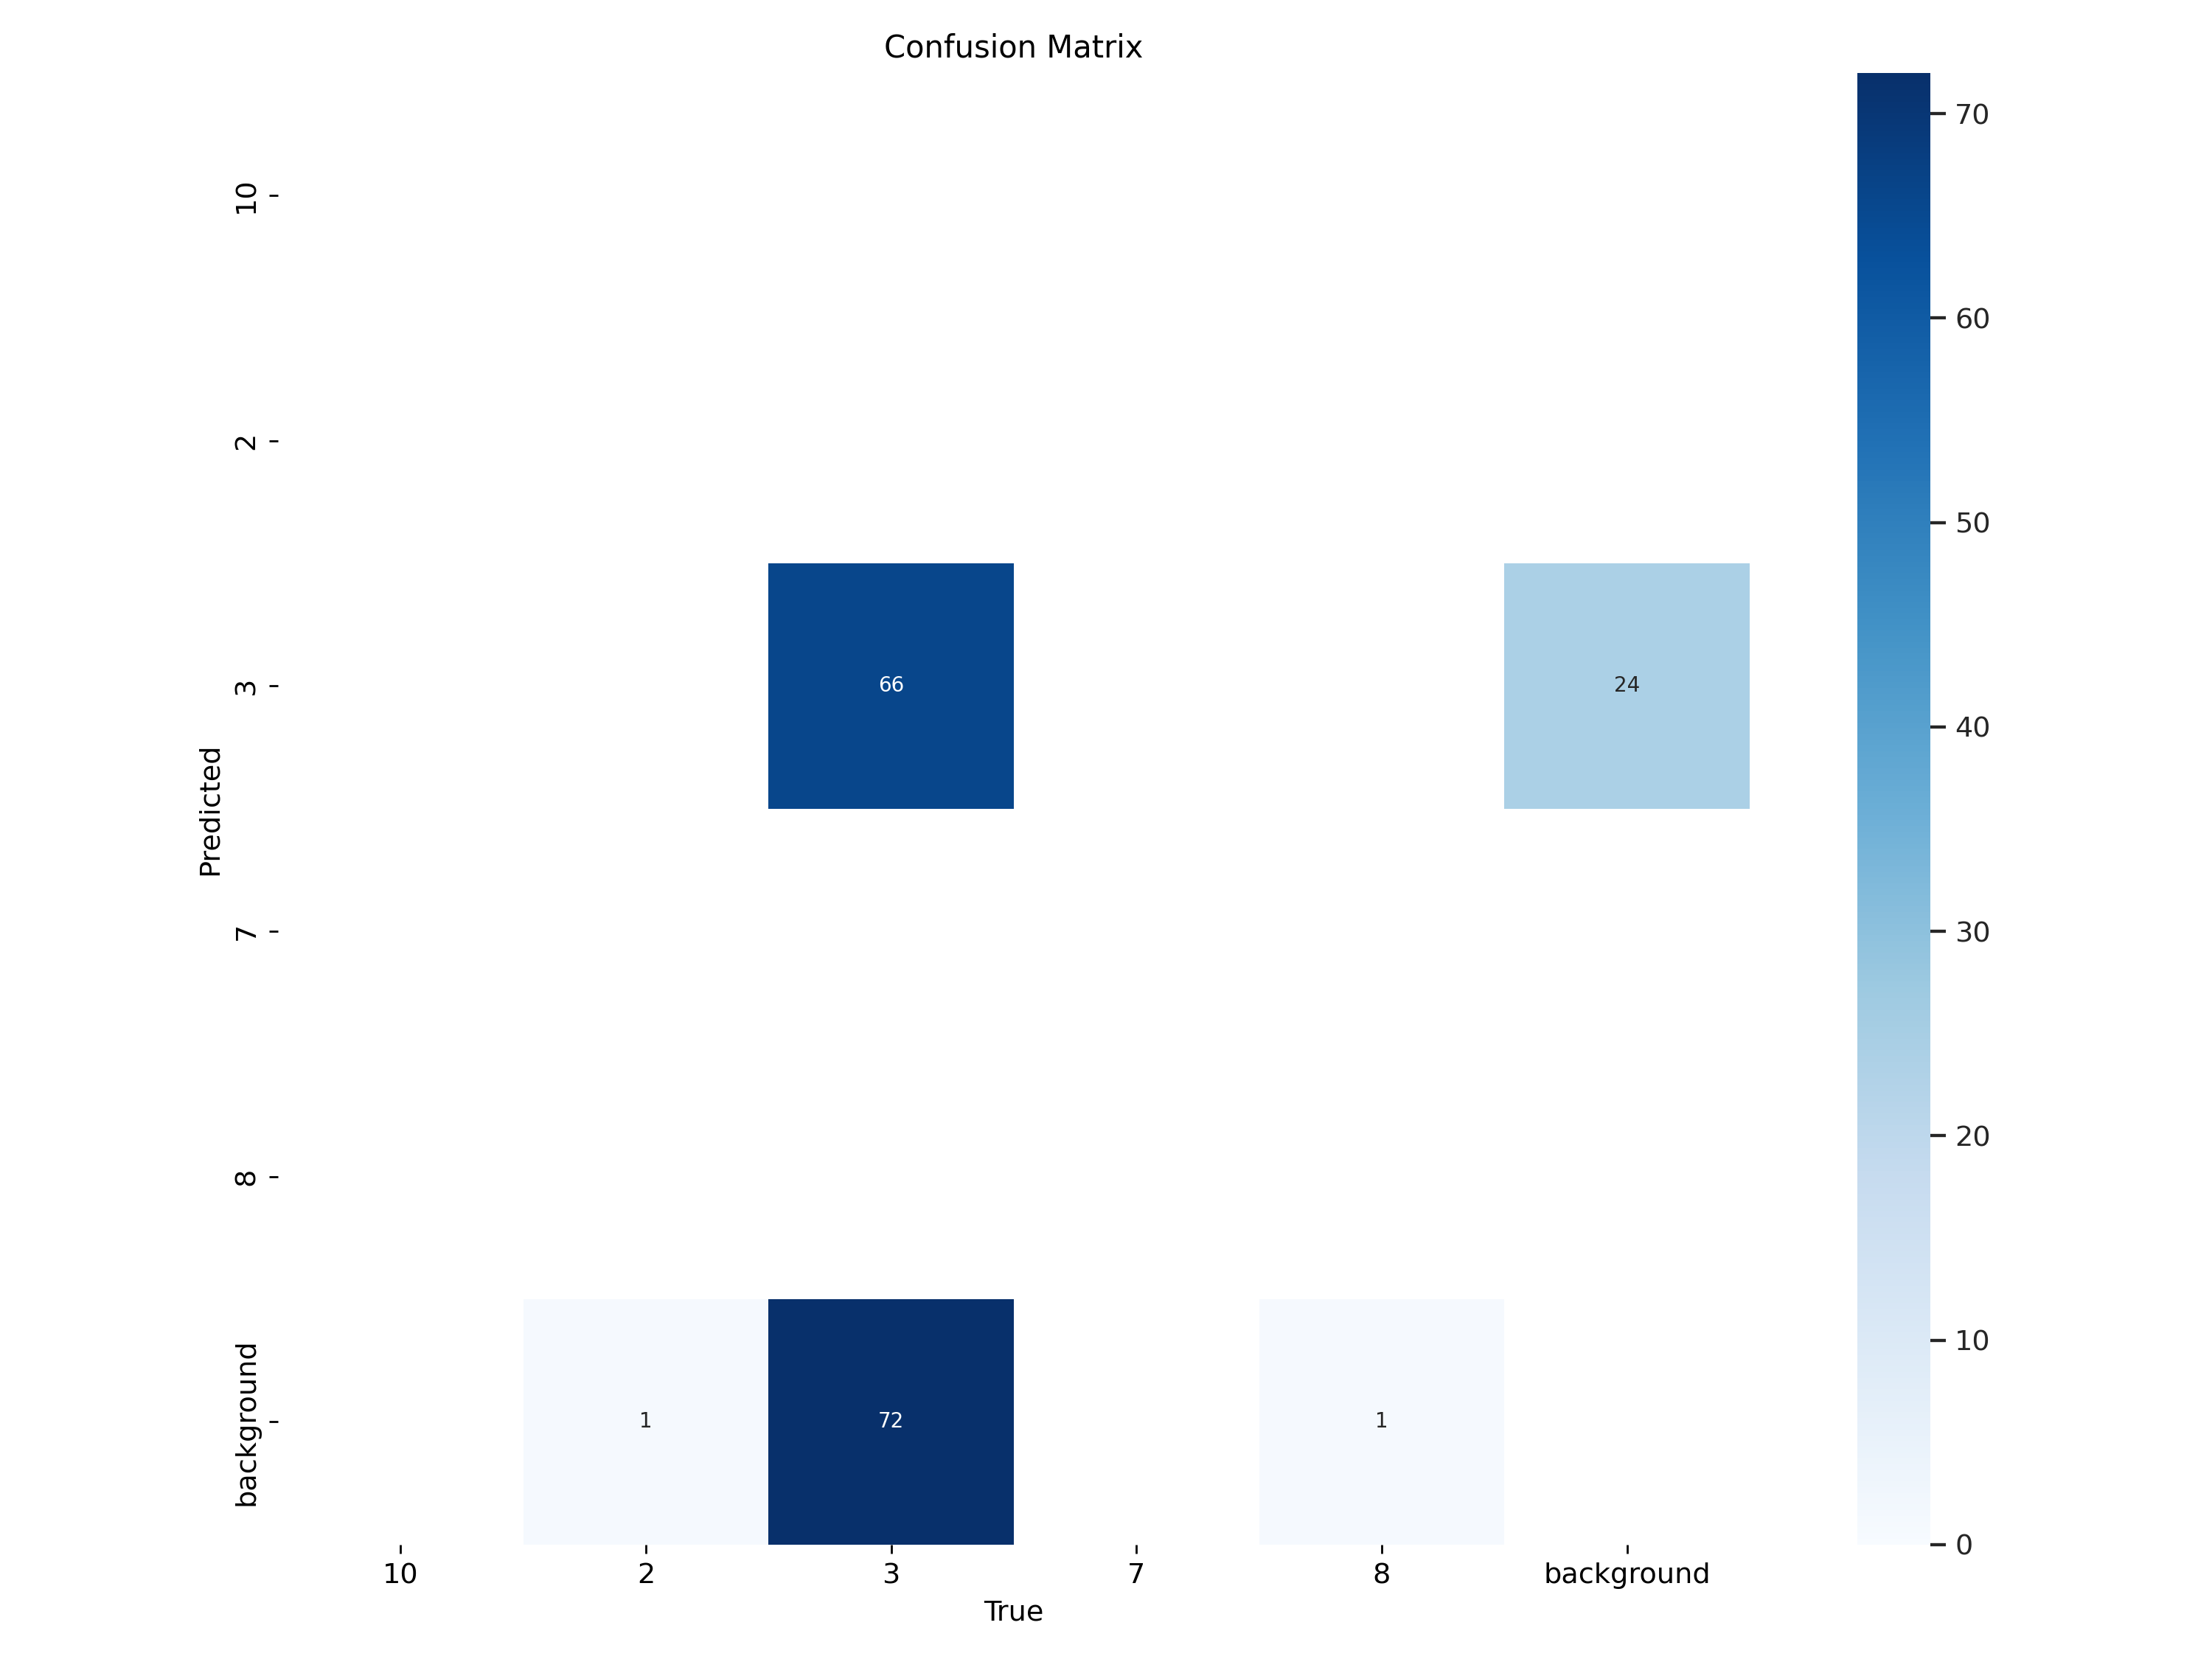

In [26]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train4/confusion_matrix.png', width=900)

/content


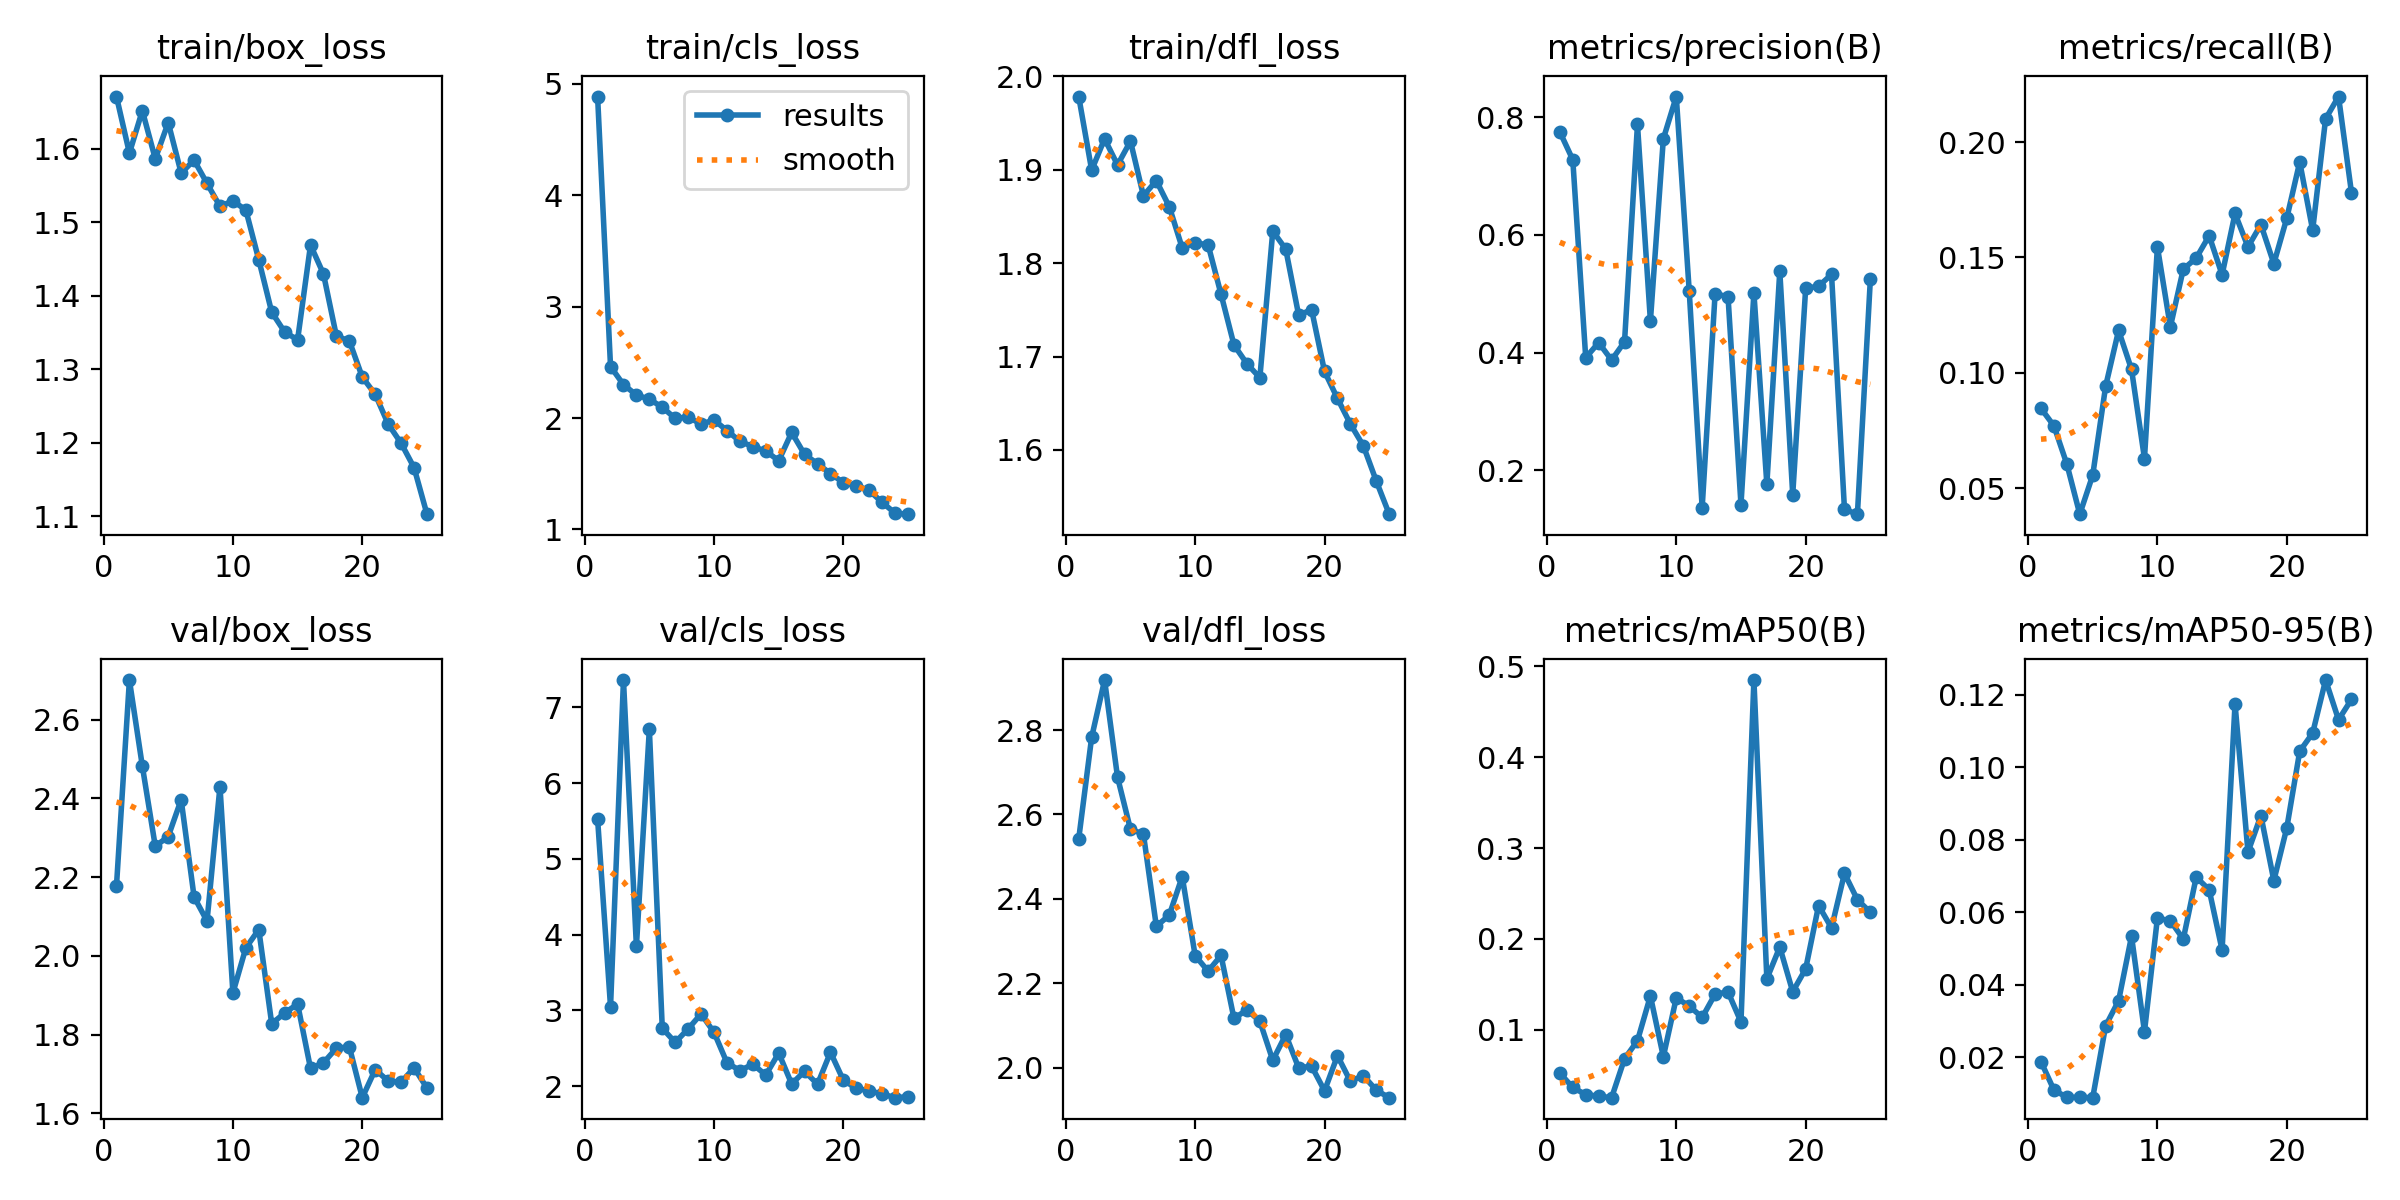

In [27]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train4/results.png', width=600)

/content


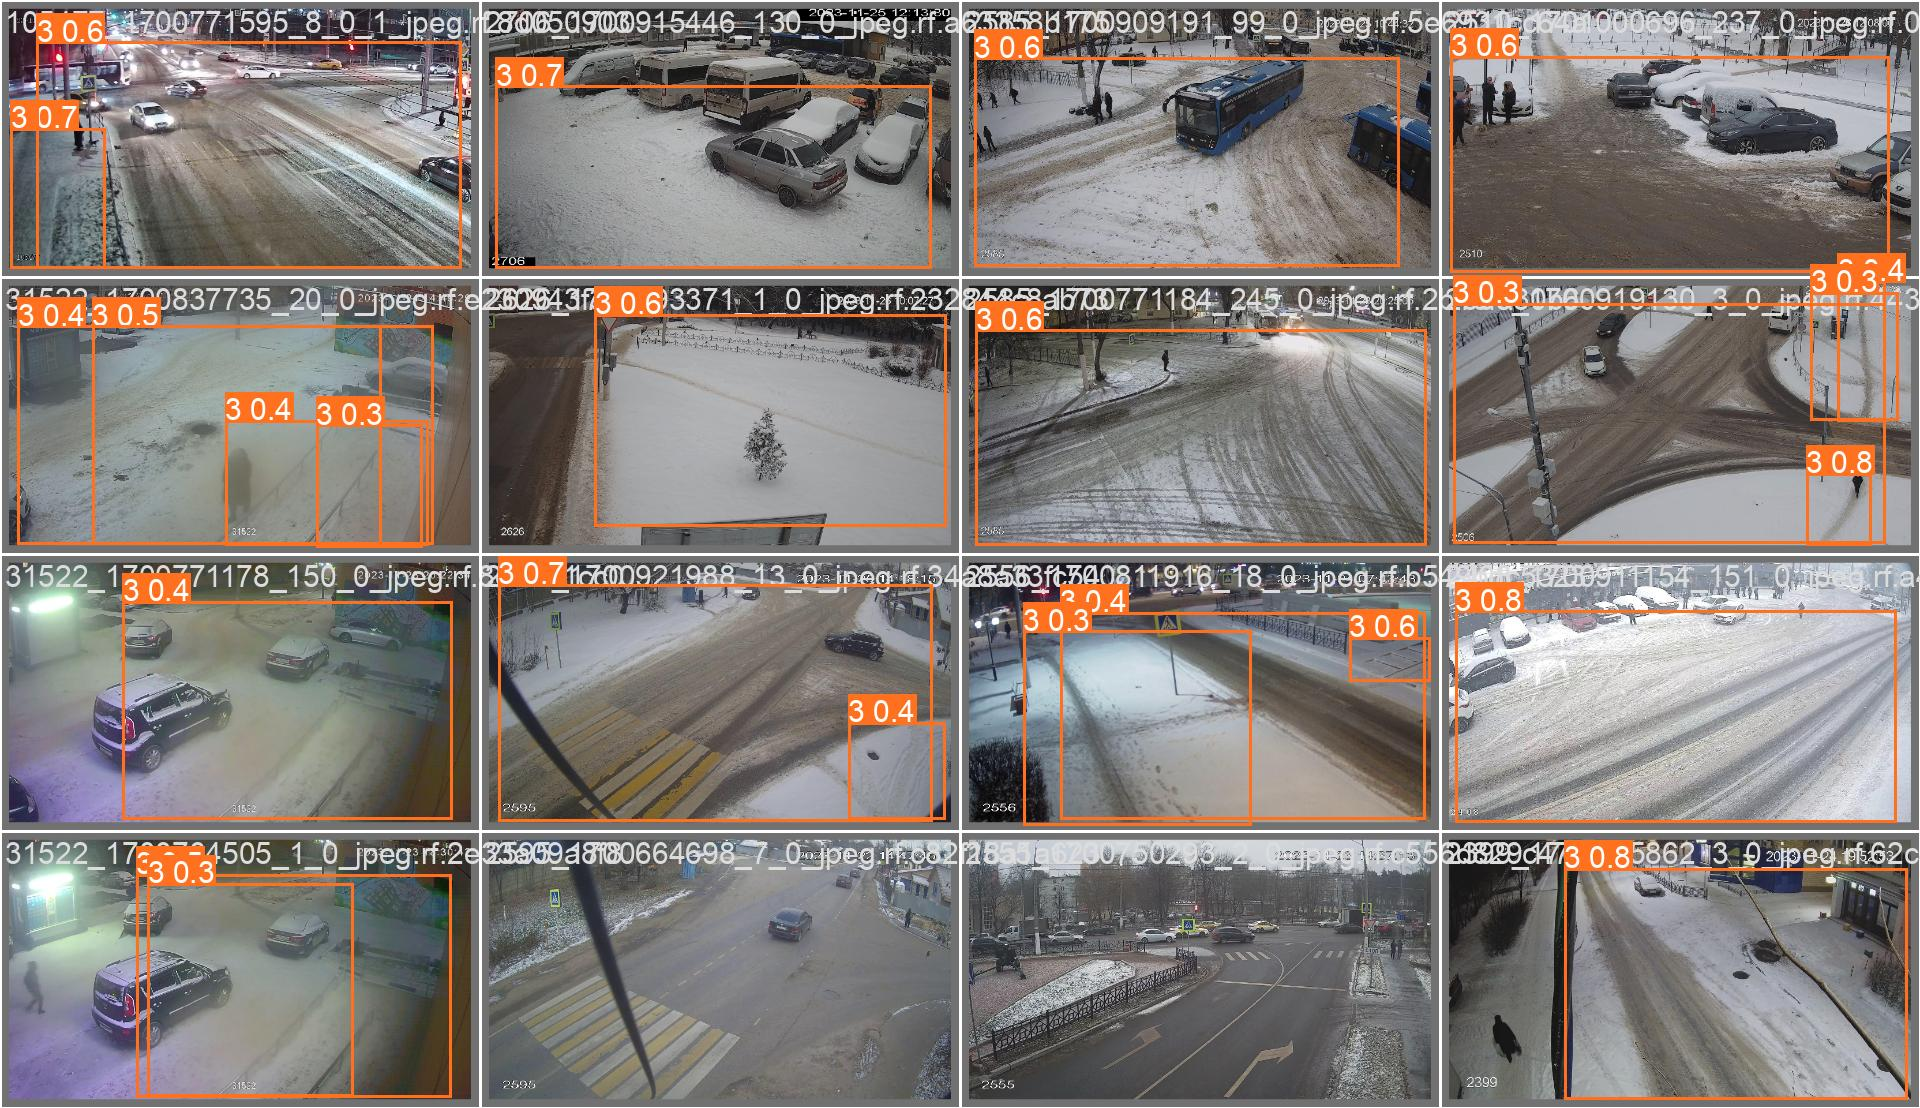

In [34]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train4/val_batch0_pred.jpg', width=1000)

## Валидация модели

In [29]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train4/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/Uncleaned-snow-3/valid/labels.cache... 117 images, 33 backgrounds, 0 corrupt: 100% 117/117 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 138, len(boxes) = 140. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:06<00:00,  1.24it/s]
                   all        117        140      0.501      0.175      0.485      0.117
                     2        117          1          1          0      0.995     0.0995
                     3        117        138      0.502      0.525       0.46      0.252
                   

## Тестирование модели

In [30]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train4/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs

image 1/52 /content/datasets/Uncleaned-snow-3/test/images/105477_1700584898_127_0_1_jpeg.rf.1b984e4e168fb2387cc85a556eb3d50e.jpg: 480x800 1 3, 89.9ms
image 2/52 /content/datasets/Uncleaned-snow-3/test/images/105477_1700812318_137_0_jpeg.rf.00ce78c270f16b7cc92b506fdd5c6e6c.jpg: 480x800 1 3, 15.7ms
image 3/52 /content/datasets/Uncleaned-snow-3/test/images/131479_1700490643_19_0_jpeg.rf.185854b430f89a1efc07a6279fe4a8c3.jpg: 480x800 (no detections), 15.7ms
image 4/52 /content/datasets/Uncleaned-snow-3/test/images/131479_1700578113_1_0_jpeg.rf.63db54d862c93c1c31e9c4e0de885cf5.jpg: 480x800 (no detections), 15.7ms
image 5/52 /content/datasets/Uncleaned-snow-3/test/images/131676_1700681258_24_0_jpeg.rf.ef3915ee496c2b15e754bf01a0ef8eac.jpg: 480x800 (no detections), 15.6ms
image 6/52 /content/datasets/Uncleaned-snow-3/t

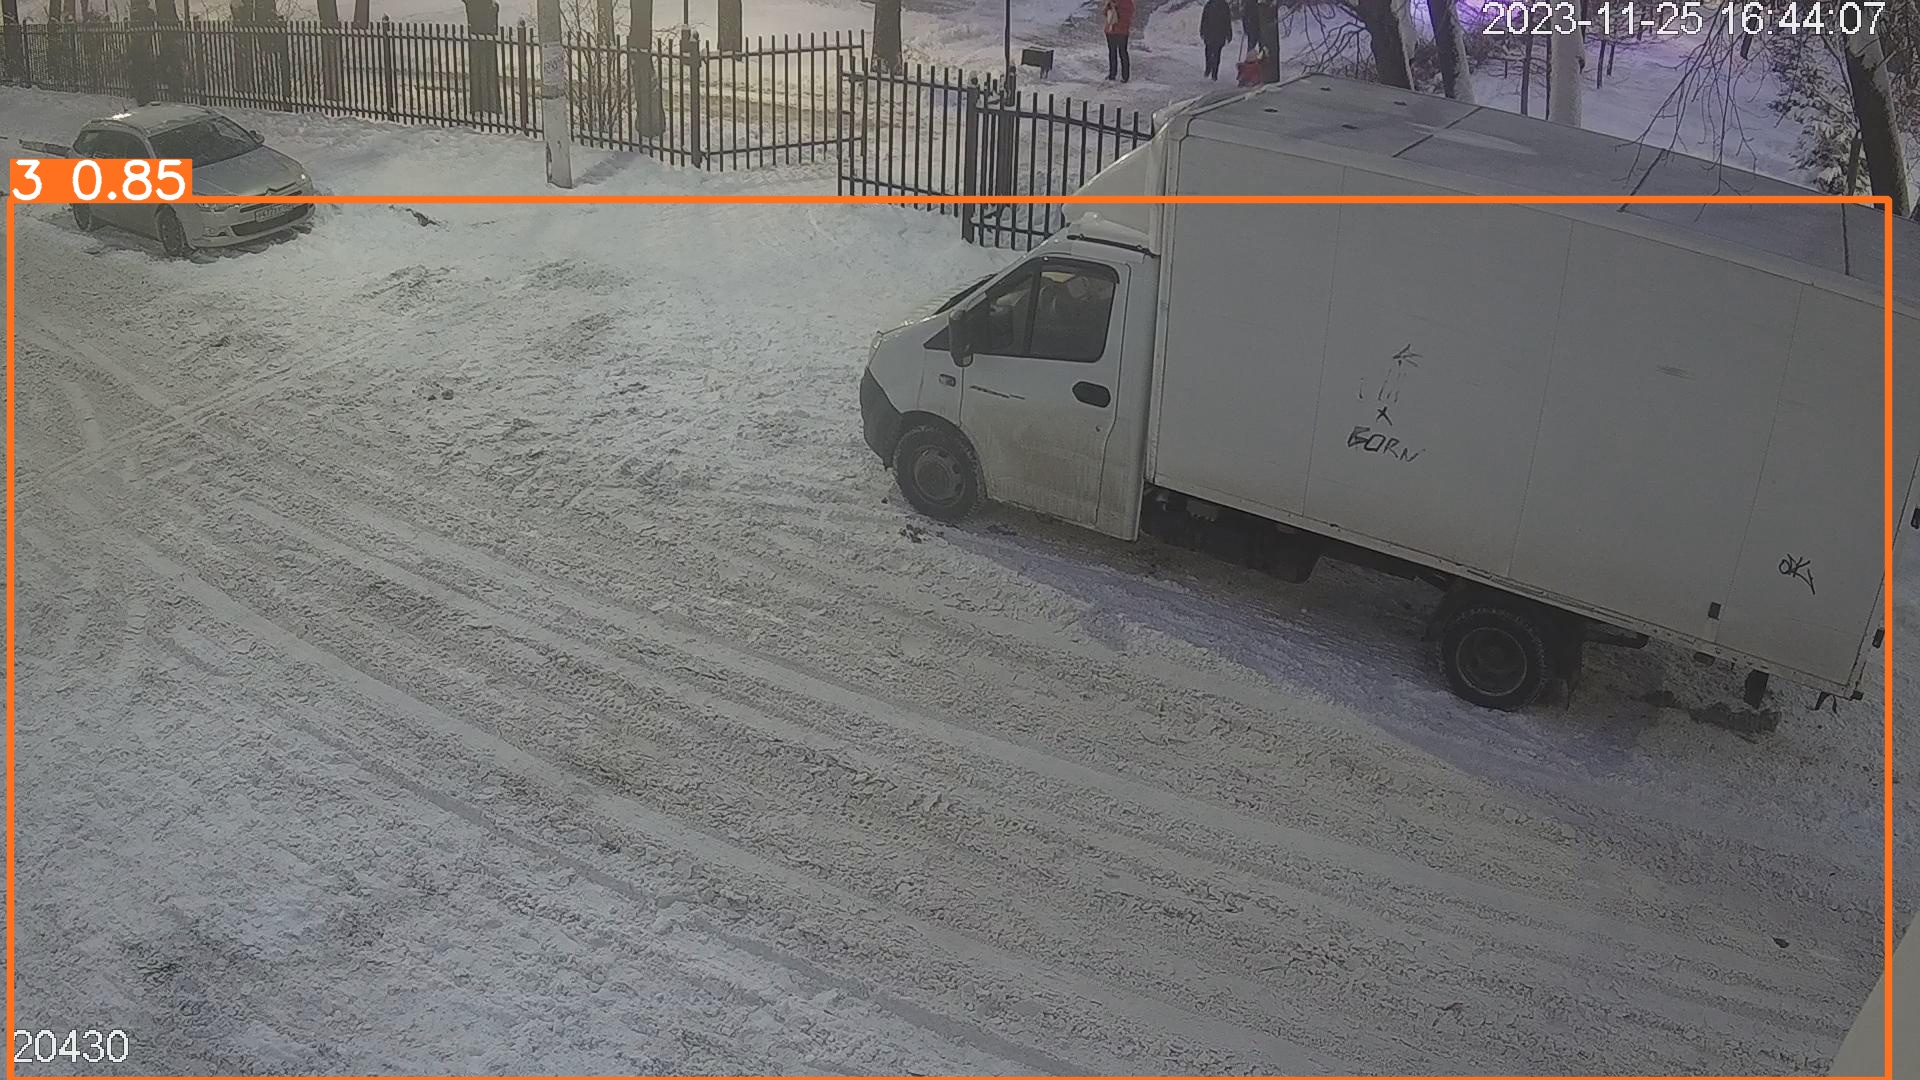

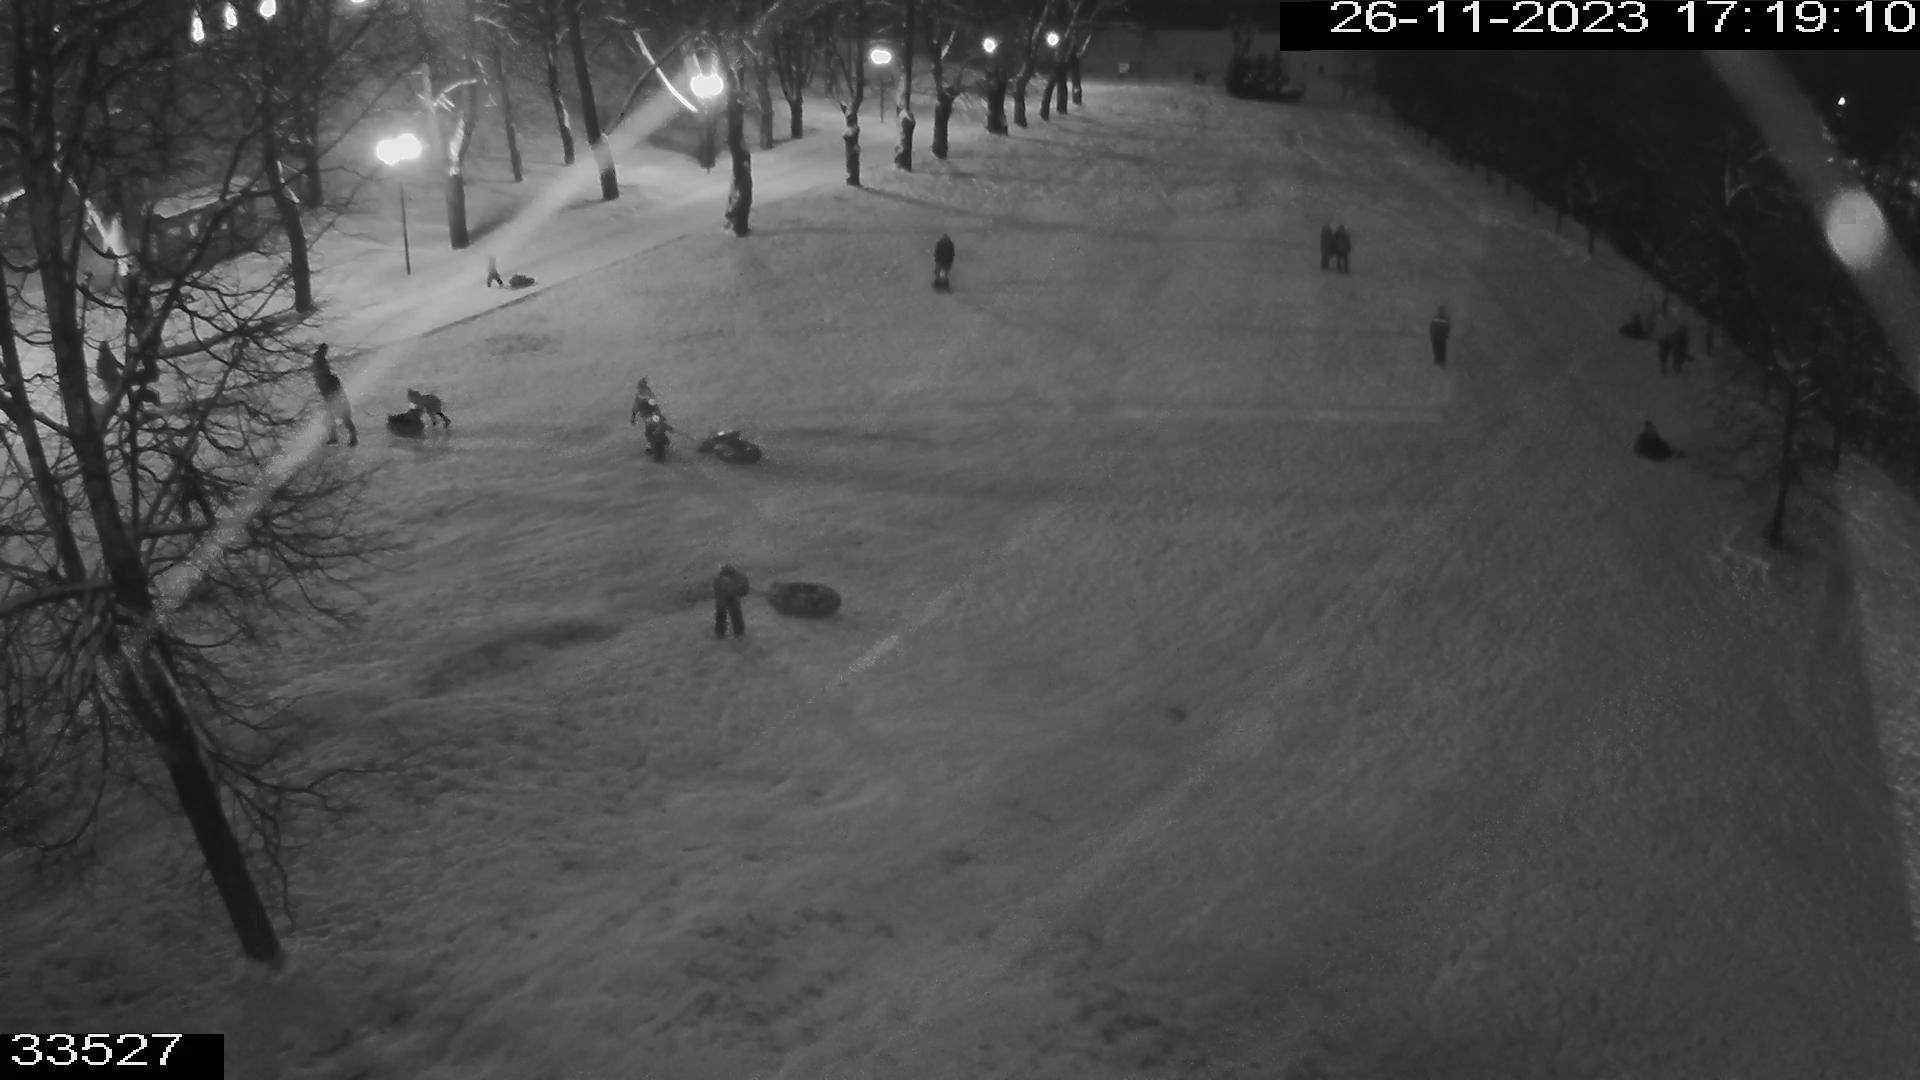

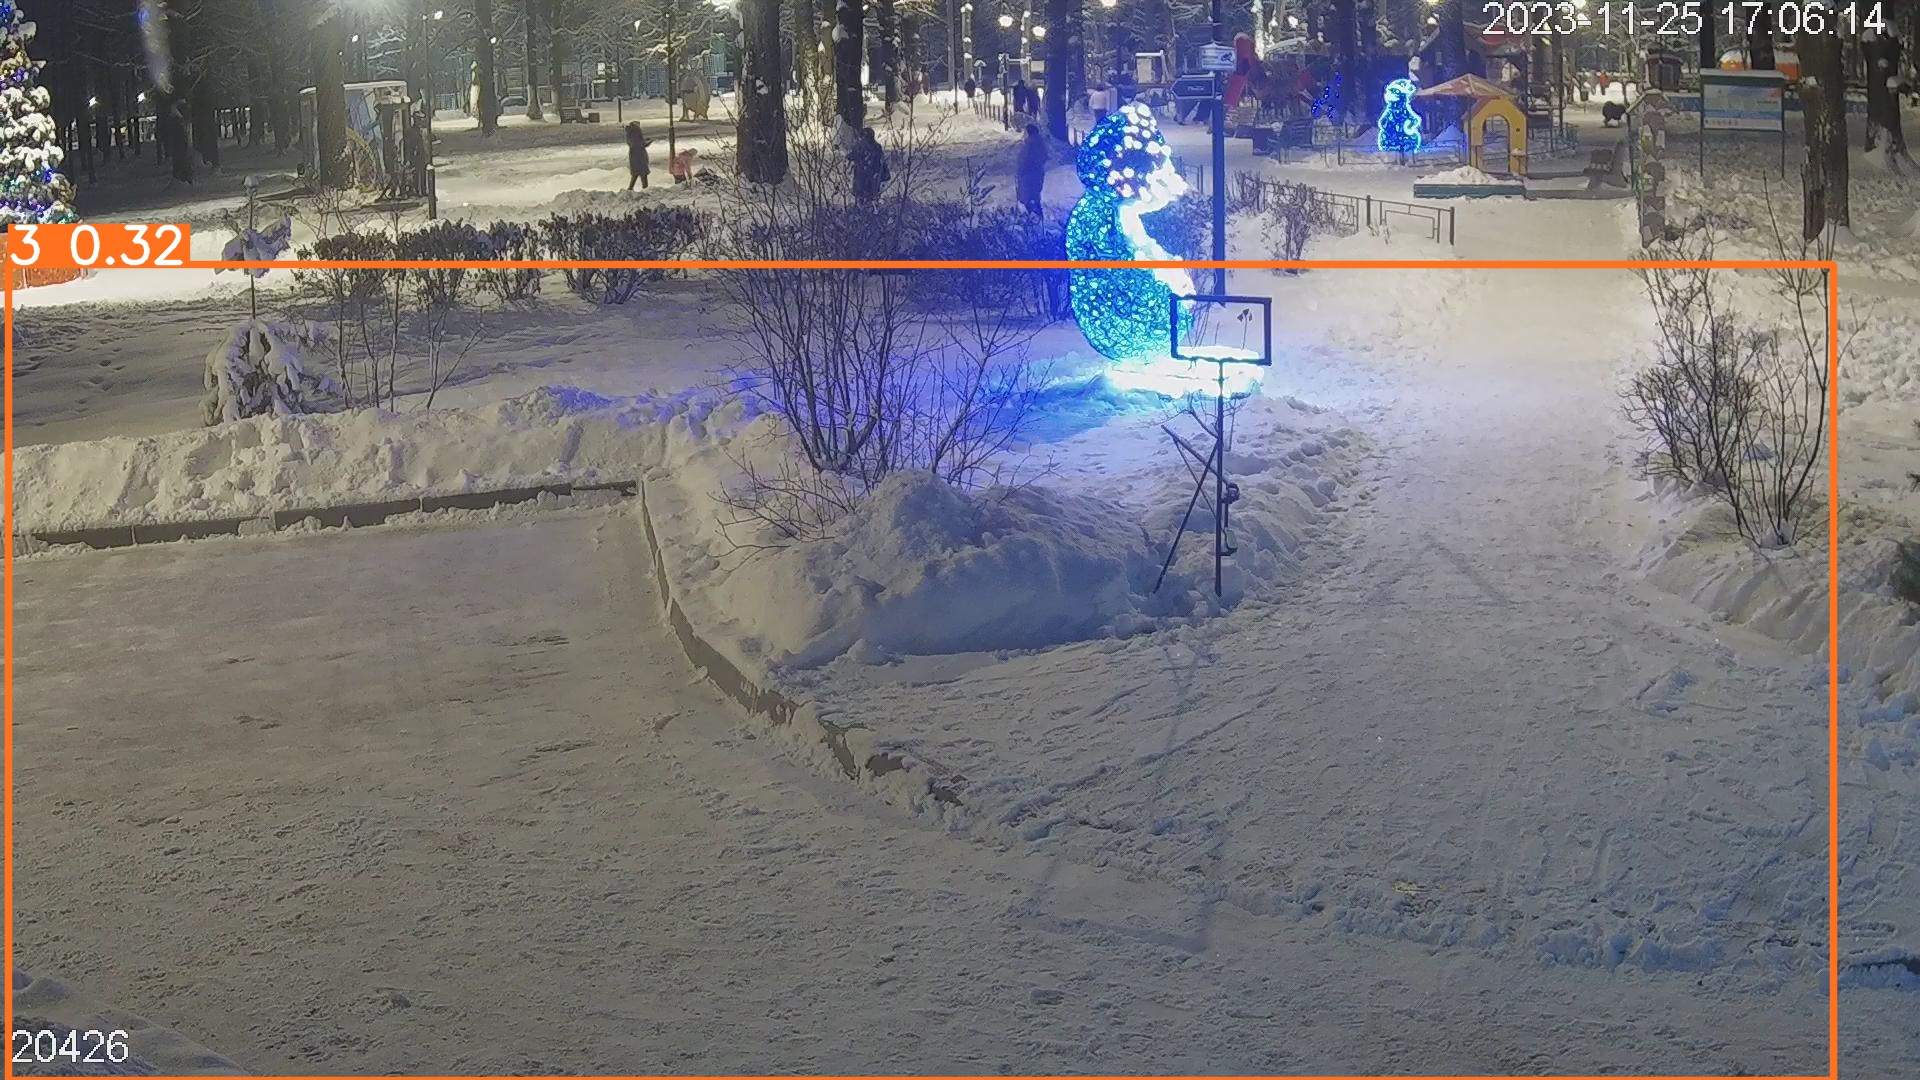

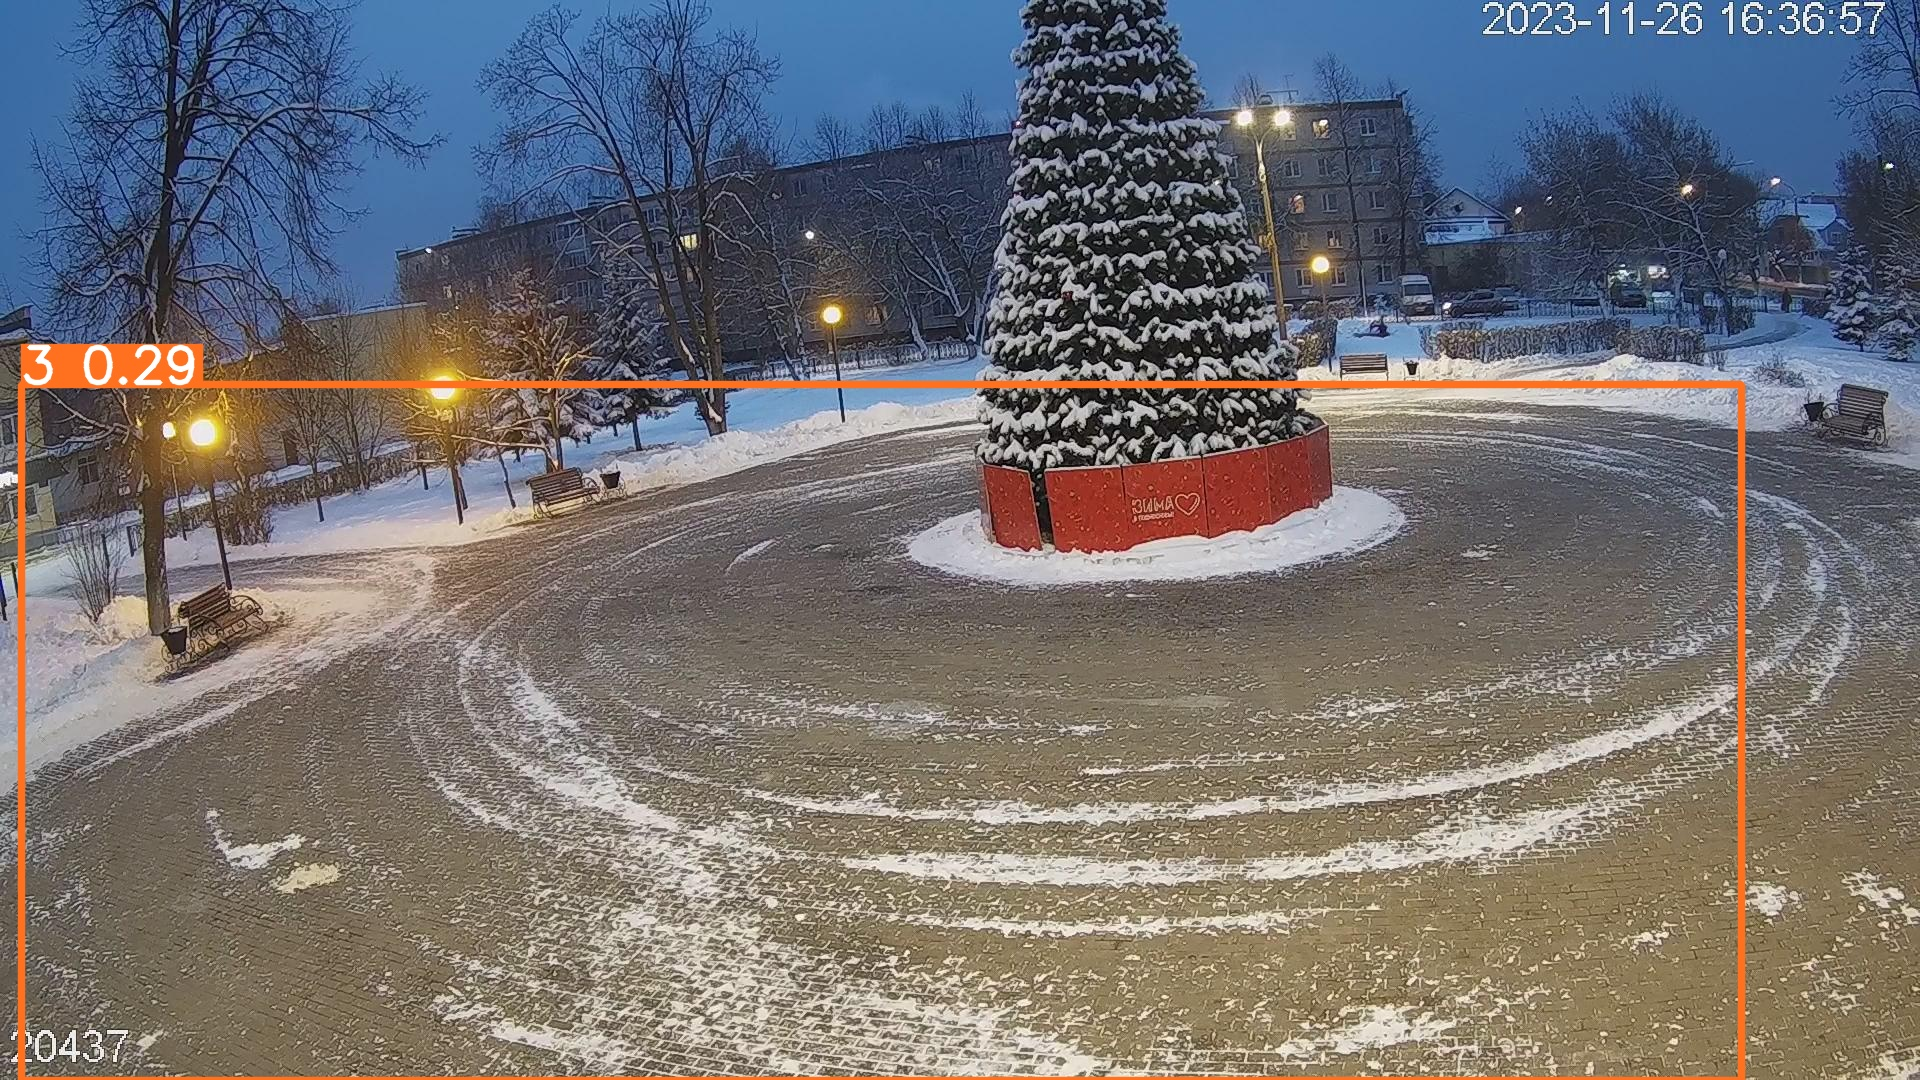

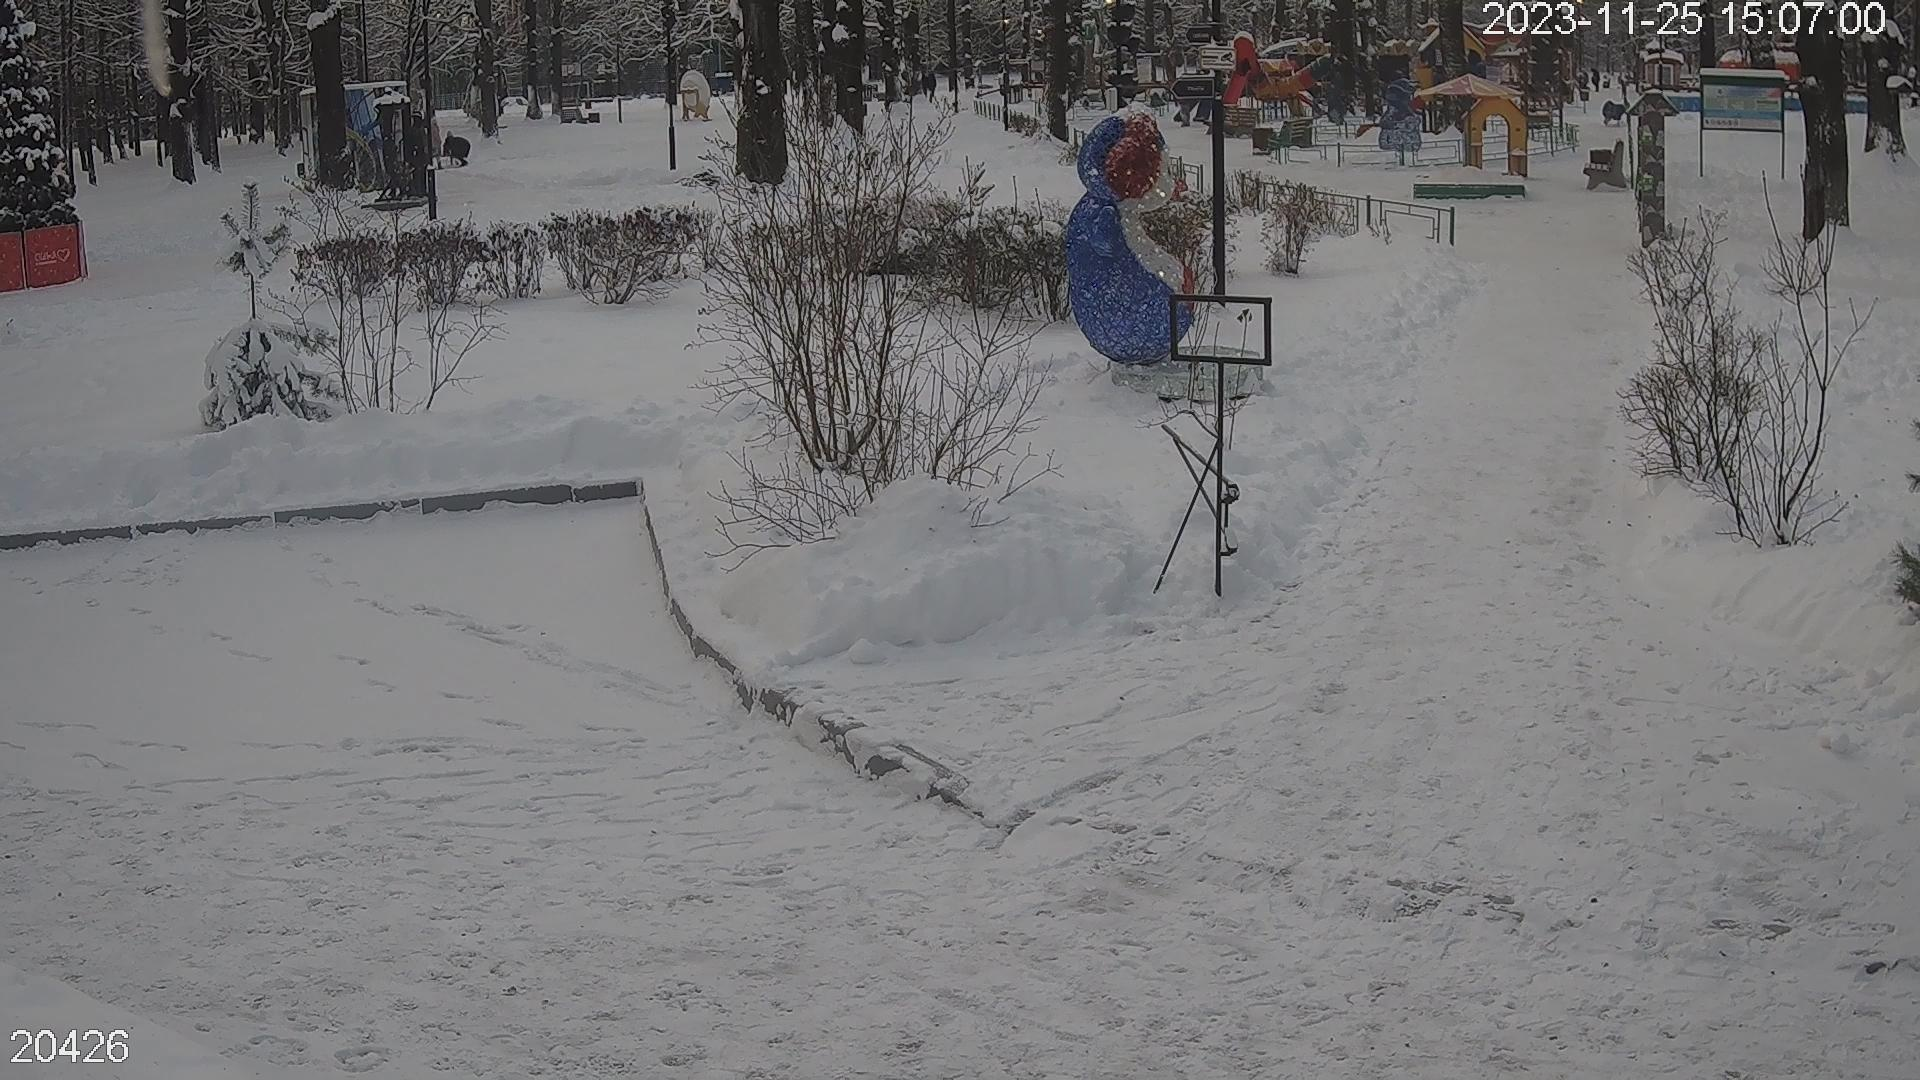

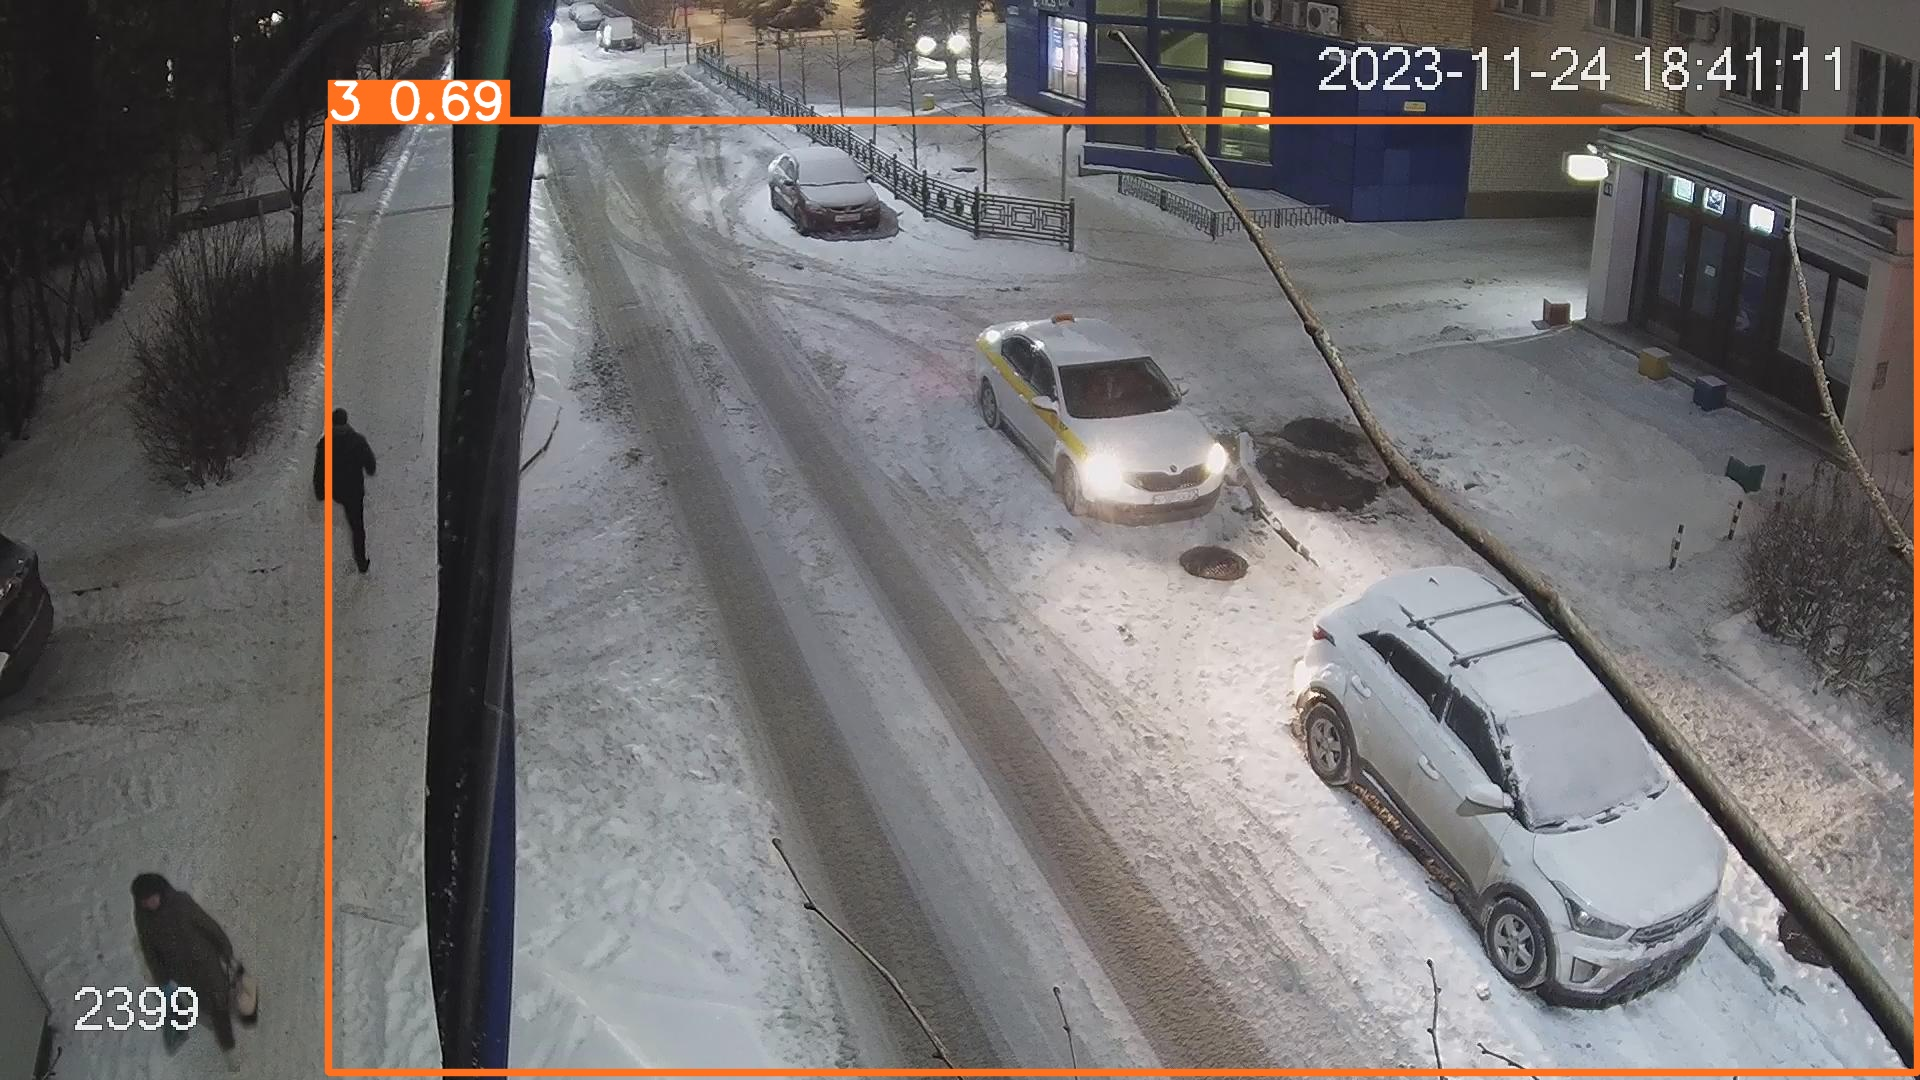

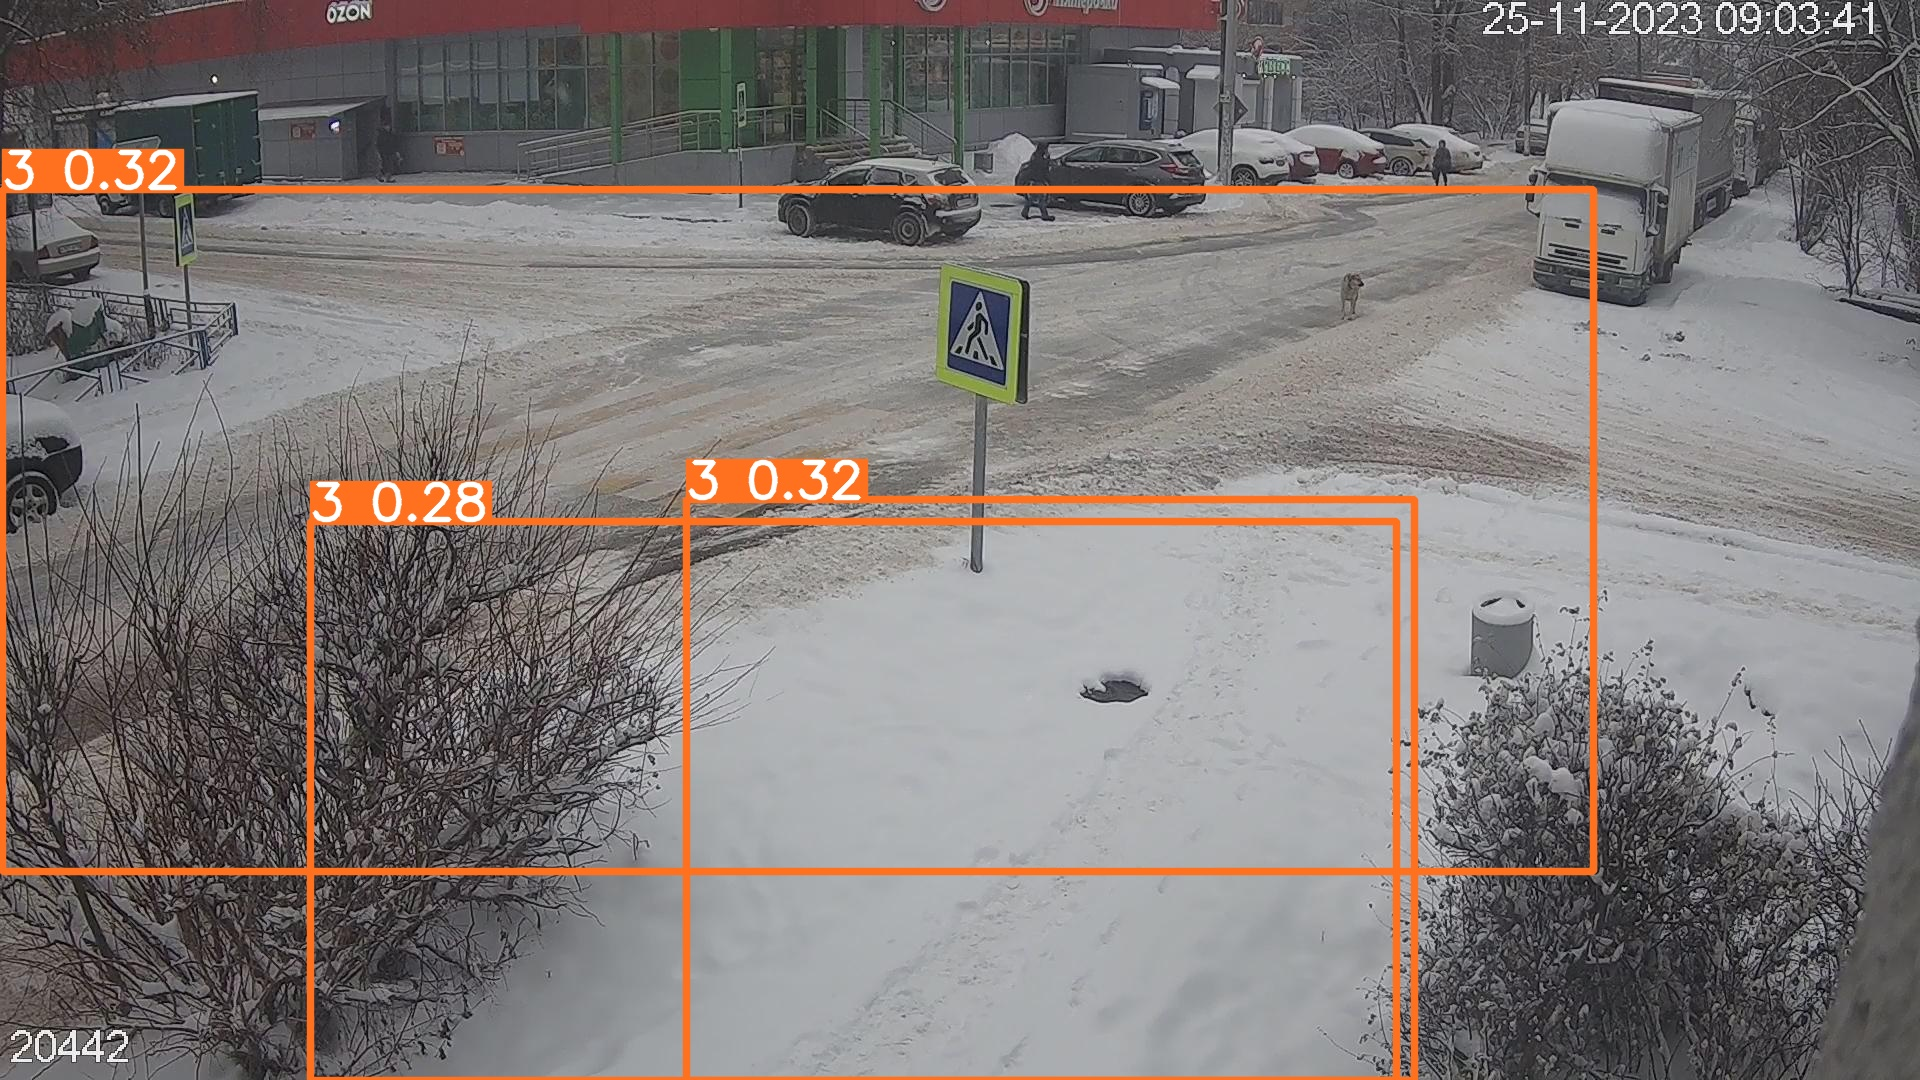

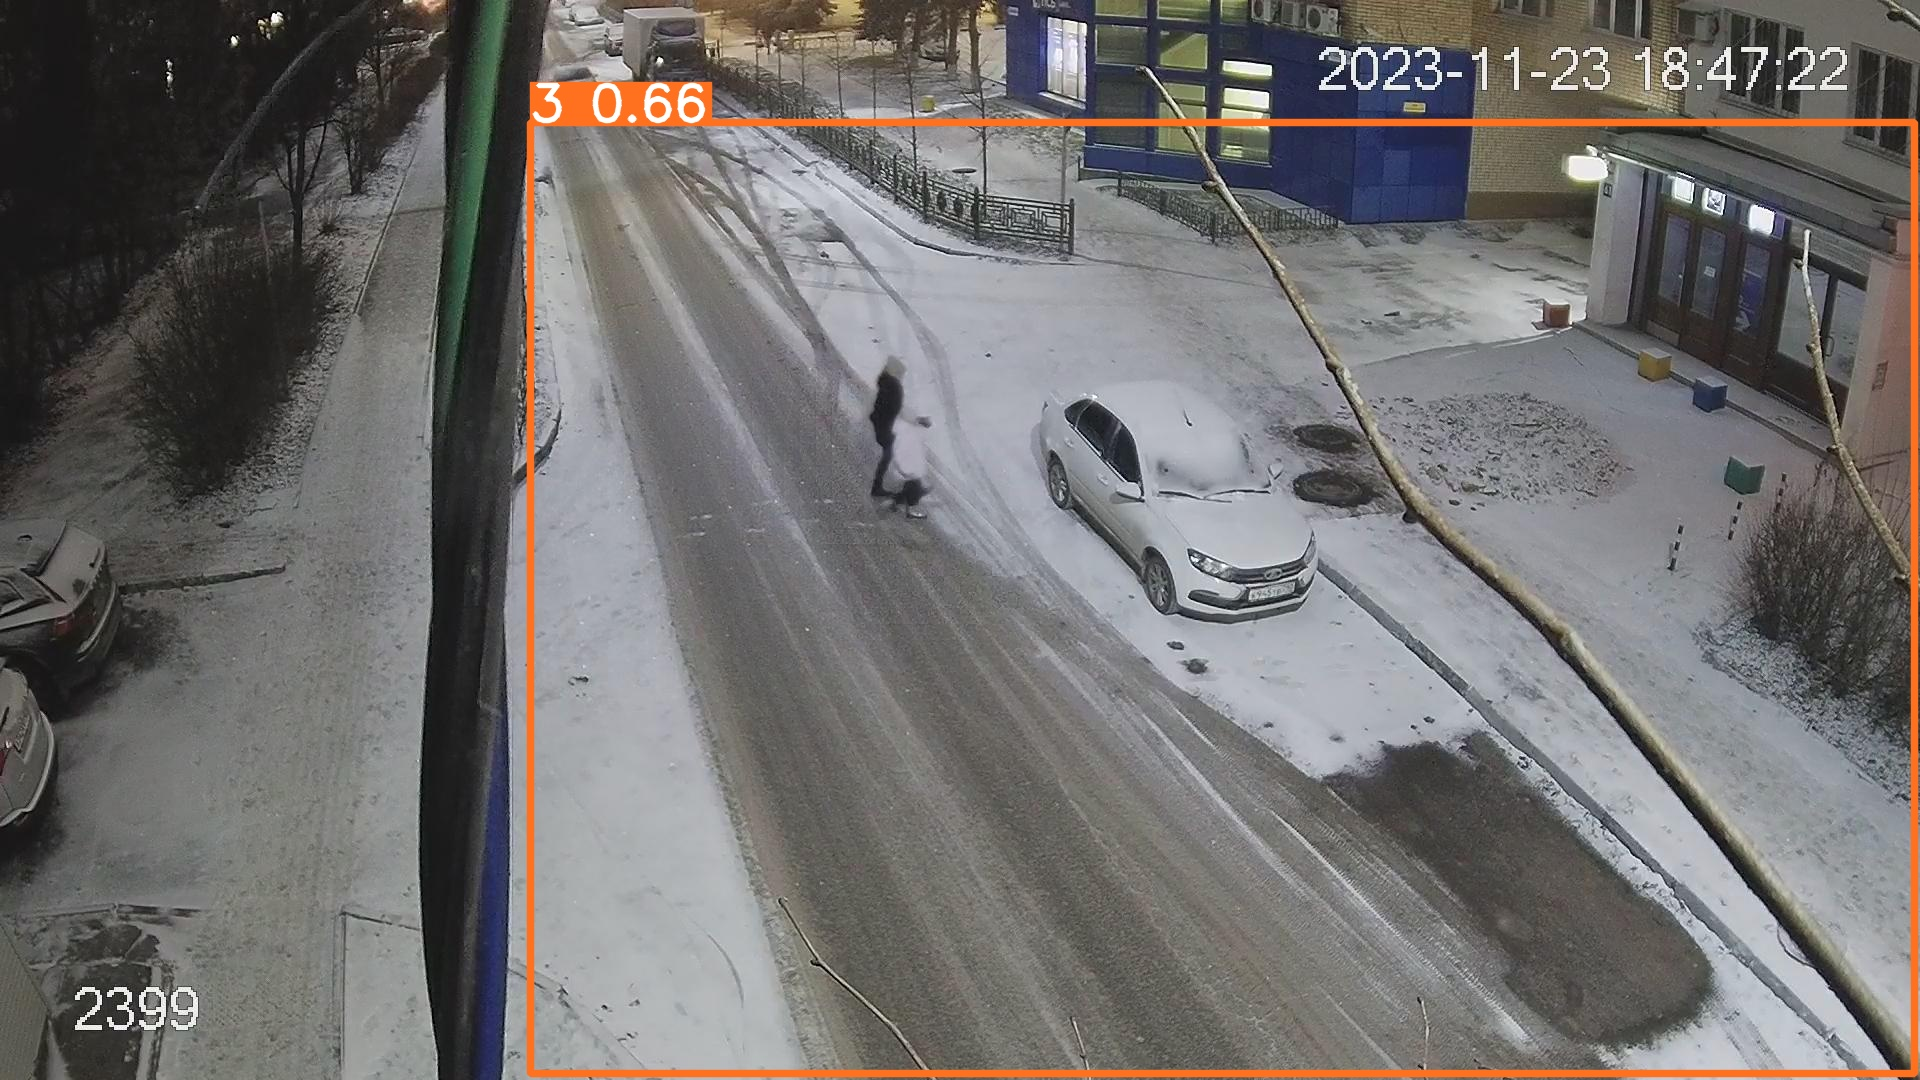

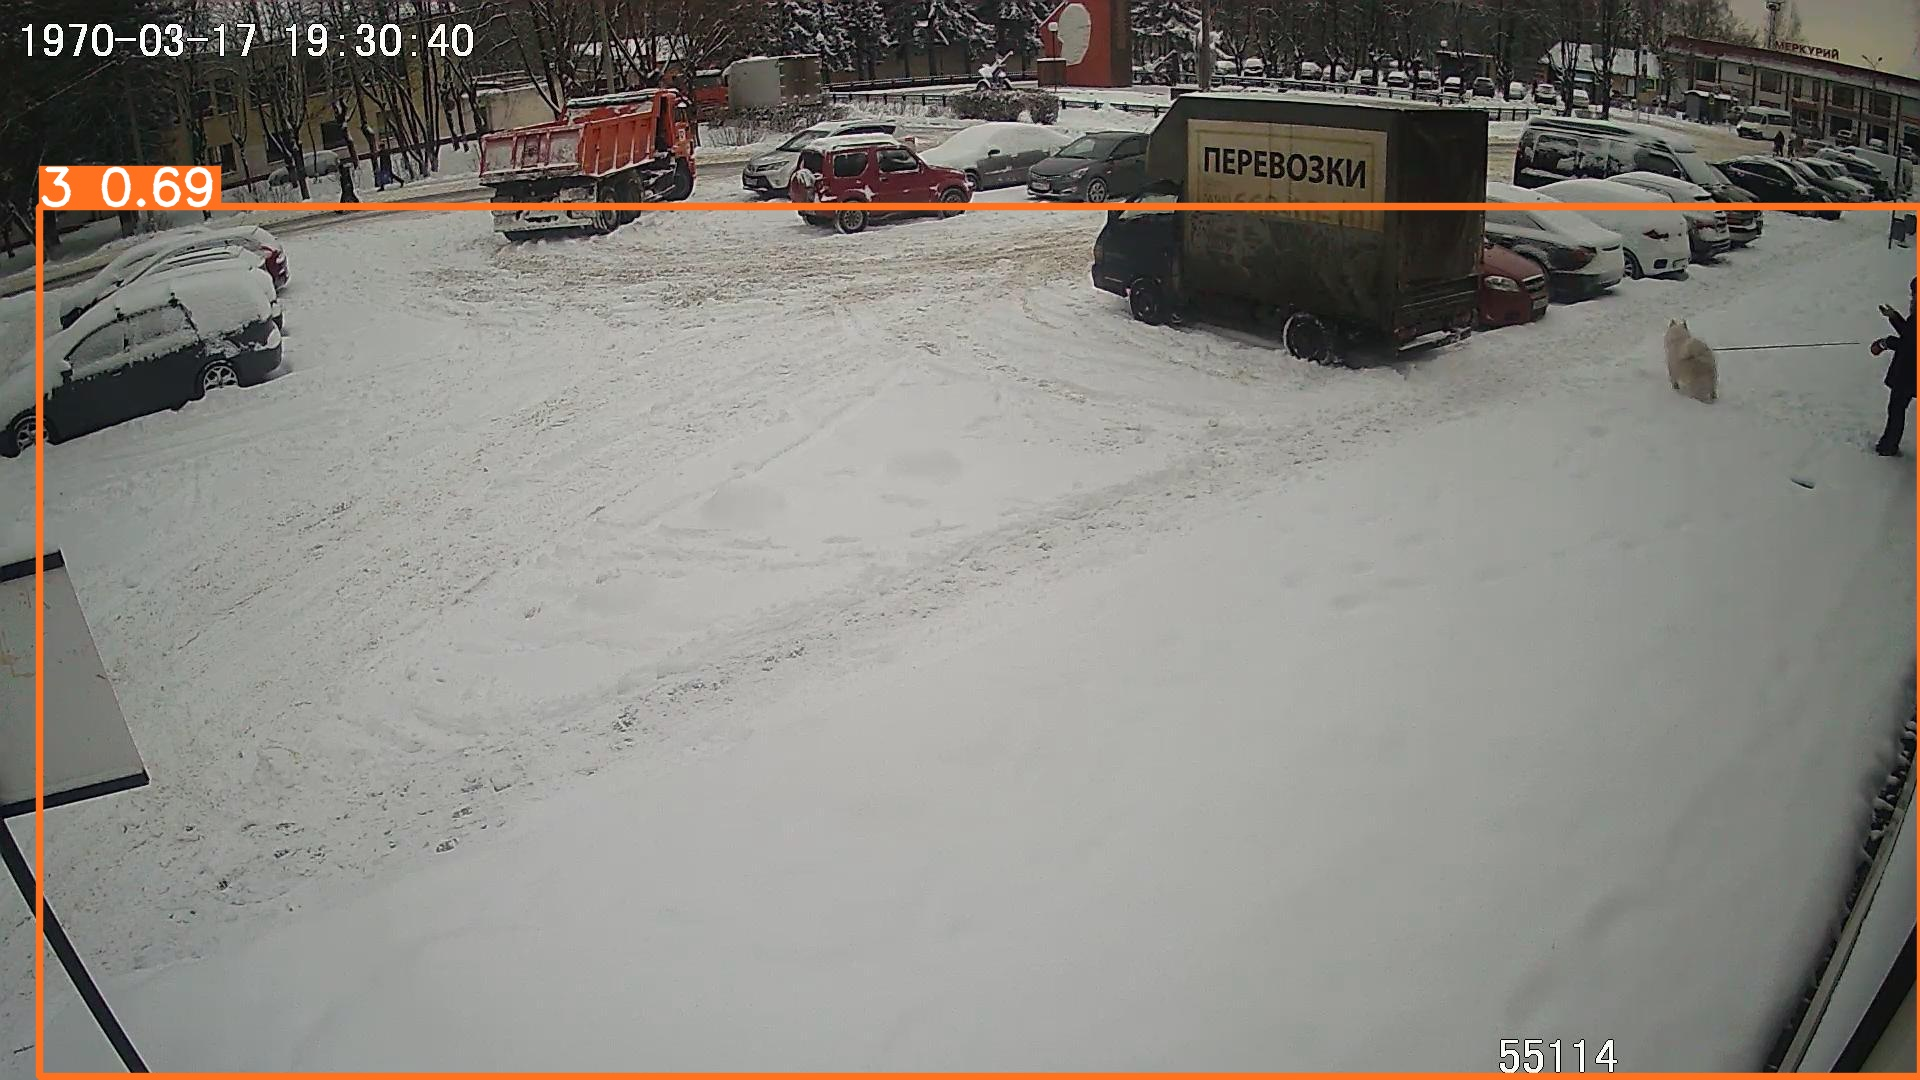

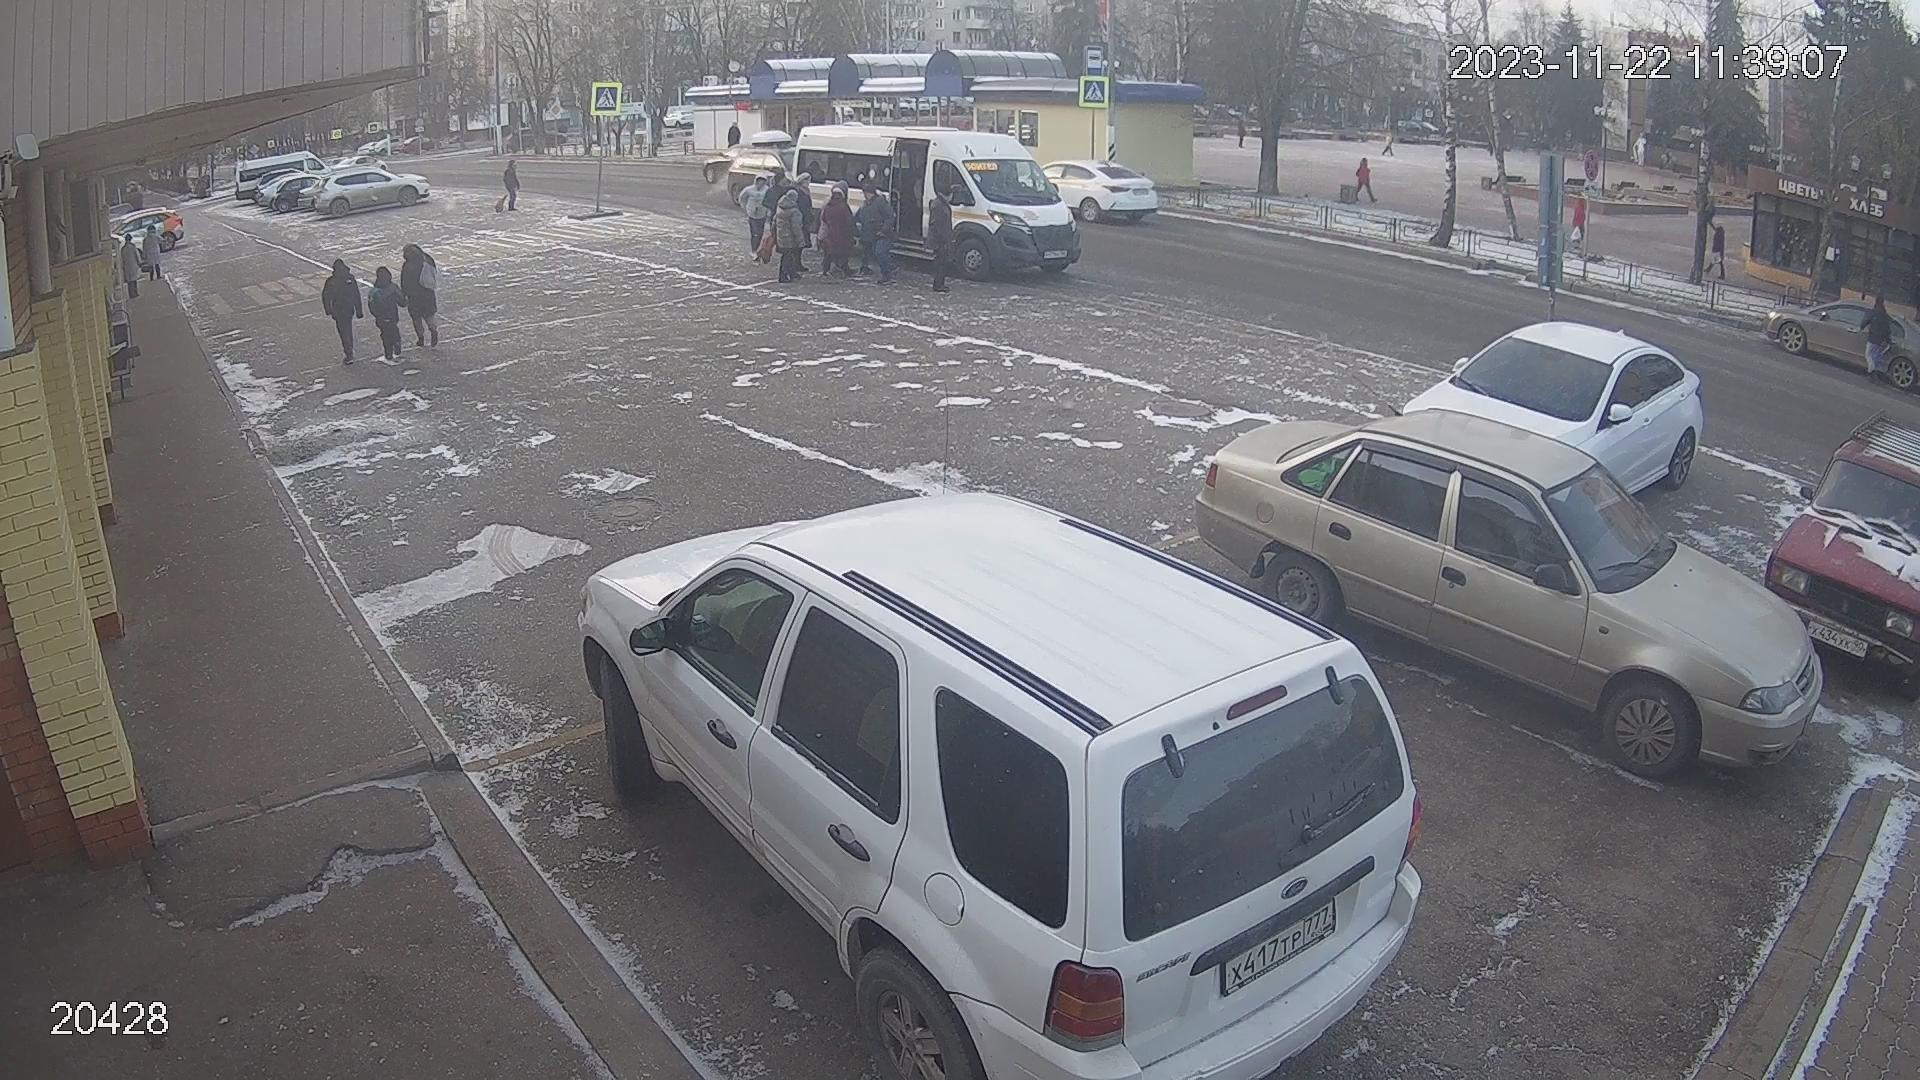

In [32]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:10]:
      display(Image(filename=image_path, width=600))
      print("\n")

Модель показала невысокий уровень (mAP50 0.46) распознавания нечищенного снега на дорогах и тротуаре. Модель нуждается в доработке. Включение датасета в общий для обучения на полном наборе данных может негативно повлиять на точность распознавания.